In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

import howtotan
tan_nll = howtotan.get_tan_nll

In [2]:
# Set random seed (for reproducibility)
seed = 1000
np.random.seed( seed )
tf.set_random_seed( seed )

In [3]:
def batch_norm( input, is_train=True, name='batch_norm' ):
    return tf.contrib.layers.batch_norm( 
        input, 
        decay=0.9, 
        updates_collections=None, 
        epsilon=1e-5, 
        scale=True, 
        is_training=is_train,
        scope=name
    )

def lrelu( x, leak=0.2, name='lrelu' ):
    return tf.maximum( x, leak * x )

# Create a simple convolutional layer
Start off by creating a simple conv layer that uses relu activations and batch normalization

In [4]:
def conv2d( input, num_channels, dh=2, dw=2, is_train=True, name='conv2d' ):
    with tf.variable_scope( name ):
        h = tf.get_variable( 
            'h', 
            [3,3,input.get_shape()[-1], num_channels], 
            initializer=tf.contrib.layers.xavier_initializer_conv2d()
        )
        
        conv = tf.nn.conv2d( 
            input, 
            h, 
            strides=[1,dh,dw,1], 
            padding='SAME'
        )
        
    return lrelu( batch_norm( conv, is_train=is_train, name="bn_"+name ) )

In [5]:
def linear( input, output_size, name='linear' ):
    with tf.variable_scope( name ):
        input = tf.contrib.layers.flatten( input )
        shape = input.get_shape().as_list()
        
        w = tf.get_variable( 
            'w', 
            [shape[1],output_size], 
            tf.float32, 
            tf.random_normal_initializer( stddev=0.01 )
        )
        
        b = tf.get_variable( 
            'b', 
            [output_size], 
            initializer=tf.constant_initializer( 0 )
        )
        
        return tf.matmul( input, w ) + b

# Serialize conv layers to create the encoder
Several stacked conv layers will create the encoder.
We reduce the number of pixels by a factor of 2 in both spatial dimensions and increase the number of channels.
For simplicity, the code size is currently hard-coded at 128.

In [6]:
def encoder( input, is_train=True ):
    with tf.variable_scope( 'encoder' ):
        ch = 32
        conv = conv2d( input, ch, dh=1, dw=1, is_train=is_train, name='testConv00' )
        ch *= 2
        conv = conv2d( conv,  ch, dh=2, dw=2, is_train=is_train, name='testConv01' )
        ch *= 2
        conv = conv2d( conv,  ch, dh=2, dw=2, is_train=is_train, name='testConv02' )
        ch *= 2
        conv = conv2d( conv,  ch, dh=2, dw=2, is_train=is_train, name='testConv03' )
        ch *= 2
        conv = conv2d( conv,  ch, dh=2, dw=2, is_train=is_train, name='testConv04' )
        
        code = linear( conv, 128, name='lin_enc' )
        
    return code
        

In [7]:
# input = tf.random_normal( (64,32,32,3) )
# code = encoder( input, is_train=True )

In [8]:
# with tf.train.MonitoredSession() as sess:
#     code_ = sess.run( code )

# Create a simple convolution transpose layer
Convolution transpose is activated by relu and then batch-normed

In [9]:
def conv2d_tran( input, num_channels, dh=2, dw=2, is_train=True, name='conv2d_tran' ):
    with tf.variable_scope( name ):
        h = tf.get_variable( 
            'h', 
            [3,3,num_channels,input.get_shape()[-1]], 
            initializer=tf.contrib.layers.xavier_initializer()
        )
        
        shape = input.get_shape().as_list()
        out_shape = tf.stack( [
            tf.shape( input )[0], 
            shape[1] * dh, 
            shape[2] * dw, 
            num_channels
        ] )
        convt = tf.nn.conv2d_transpose( 
            input, 
            h, 
            output_shape=out_shape, 
            strides=[1,dh,dw,1]
        )
        
    return tf.layers.batch_normalization( tf.nn.relu( convt ), training=is_train )

# Serialize conv^T layers to create the decoder
Several stacked conv^T layers will create the decoder.
The first few layers expand the pixels by a factor of 2 in both spatial dimensions and decreases the number of channels.
After the original data size has been achieved, the output is activated by sigmoid so the reconstruction will be on the same scale as the input (0 to 1).

In [10]:
def decoder( code, is_train=True ):
    with tf.variable_scope( 'decoder' ):
        convt = tf.expand_dims( tf.expand_dims( code, axis=1 ), axis=1 )
        
        convt = conv2d_tran( convt, 100, dh=2, dw=2, is_train=True, name='conv2dt00' )
        convt = conv2d_tran( convt,  80, dh=2, dw=2, is_train=True, name='conv2dt01' )
        convt = conv2d_tran( convt,  64, dh=2, dw=2, is_train=True, name='conv2dt02' )
        convt = conv2d_tran( convt,  48, dh=2, dw=2, is_train=True, name='conv2dt03' )
        convt = conv2d_tran( convt,  32, dh=2, dw=2, is_train=True, name='conv2dt04' )
        
        # This is simpler as a convolution than a convolution transpose
        output = conv2d( convt, 3, dh=1, dw=1, is_train=True, name='output' )
        
    return tf.nn.sigmoid( output ) # smoothly "clip" the batch-normed values

Some simple code for testing

In [11]:
# recon = decoder( code )
# with tf.train.MonitoredSession() as sess:
#     recon_ = sess.run( recon )

The autoencoder is just the encoder and the decoder in serial. We will output the reconstruction and the code.

In [12]:
def autoencoder( input, is_train=True ):
    with tf.variable_scope( 'autoencoder' ):
        code = encoder( input )
        recon = decoder( code )
        
        return recon, code

The next 2 cells are more testing. This time we will execute the graph. Note, this will not train the graph, just make sure that it will run. We still need to add a loss and optimizer before we can train. Additionally, we haven't loaded any data.

In [13]:
# input = tf.random_normal( (64,32,32,3) )
# recon, code = autoencoder( input )

In [14]:
# with tf.Session() as sess:
#     sess.run( [tf.local_variables_initializer(), tf.global_variables_initializer()] )
#     
#     recon_, code_ = sess.run( [recon, code] )

In [15]:
def code2labels( code, is_train=True ):
    with tf.variable_scope( 'code2labels' ):
        lin    = lrelu( batch_norm( linear( code, 32, 'label00'), is_train=is_train ) )
        labels = linear( code, 10, 'label01')
        
    return labels

In [16]:
HEIGHT = 32
WIDTH  = 32
DEPTH  = 3

TOT_TRAIN_EX = 10000
TOT_TEST_EX  = 10000
EPOCHS = 30

Set the tunable parameters

In [17]:
train_batch_size = 64
test_batch_size  = 64
batch_size = tf.placeholder( tf.int64 )
is_train   = tf.placeholder( tf.bool )
train_on_full = False # True # train on our prebuilt, subset or the full set

# if ( train_on_full ):
#     num_classes = 10
# else:
#     num_classes = 2
# print( "Building one-hot vectors with {} classes".format( num_classes ) )

Create the functions to read a single example and to augment a single example

In [18]:
def parser( example ):
    features = tf.parse_single_example( 
        example, 
        features={
            'image': tf.FixedLenFeature( [], tf.string ),
            'label': tf.FixedLenFeature( [], tf.int64 )
        }
    )
    
    image = tf.decode_raw( features[ 'image' ], tf.uint8 )
    image.set_shape( [DEPTH * HEIGHT * WIDTH] )
    
    image = tf.cast( 
        tf.transpose( 
            tf.reshape( 
                image, [DEPTH, HEIGHT, WIDTH] ), 
            [1,2,0] ), # [0,1,2] ), #
        tf.float32
    ) / 255
    label = tf.one_hot( tf.cast( features[ 'label' ], tf.int32 ), 10 )
    
    return image, label

def augmenter( example ):
    data, label = parser( example )
    
    # TODO: Augment the data
    
    return data, label

Create the various datasets from the tfrecords files

In [19]:
if ( train_on_full ):
    training_fname = "./data/full/cifar-010-bin/data.tfrecords"
    ckpt_fname = "./ckpt/cifar-010-full_{}_{}.ckpt".format( EPOCHS, batch_size )
else:
    training_fname = "./data/partial/cifar-010-bin/data.tfrecords"
    ckpt_fname = "./ckpt/cifar-010-partial_{}_{}.ckpt".format( EPOCHS, batch_size )

# Always test on the full set
testing_fname  = "./data/full/cifar-010-bin/test_batch.tfrecords"

training_dataset = tf.data.TFRecordDataset( training_fname )
# Dropping the remainder makes my life easier but is suboptimal.
# It would be better to build a network that can handle variable batch sizes.
training_dataset = training_dataset.map( 
    augmenter,
    num_parallel_calls=train_batch_size
)
training_dataset = training_dataset.batch( batch_size, drop_remainder=True )
min_queue_ex = int( 0.4 * TOT_TRAIN_EX ) # This seems like a lot of examples
training_dataset = training_dataset.shuffle( buffer_size=min_queue_ex + 3 * batch_size )

testing_dataset = tf.data.TFRecordDataset( testing_fname )
testing_dataset = testing_dataset.map( 
    parser,
    num_parallel_calls=train_batch_size
)
testing_dataset = testing_dataset.batch( batch_size, drop_remainder=True )

Create the iterators from the datasets

In [20]:
iterator = tf.data.Iterator.from_structure( 
    training_dataset.output_types, 
    training_dataset.output_shapes
)

images, labels = iterator.get_next()

# We want to train the encoder so we can get access to the codes for likelihood estimation
# The simplest way to do this is to train the encoder-decoder pair with some reconstruction loss
code  = encoder( images, is_train=is_train )
recon = decoder( code, is_train=is_train )
est_labels = code2labels( code, is_train=is_train )

recon_loss = tf.losses.mean_squared_error( recon, images )
class_loss = tf.losses.softmax_cross_entropy( labels, est_labels )

loss = 10 * recon_loss + class_loss

global_step = tf.Variable(0, trainable=False)
learning_rate = tf.train.exponential_decay( 
    learning_rate=0.0005, 
    global_step=global_step,
    decay_steps=int( ( 50000 / ( 2 * train_batch_size ) ) ), 
    decay_rate=0.95, 
    staircase=True
)

# train_op = tf.train.MomentumOptimizer( learning_rate=learning_rate, momentum=0.9 ).minimize( loss )
# train_op = tf.train.AdamOptimizer( learning_rate=learning_rate ).minimize( loss )
train_op = tf.train.RMSPropOptimizer( learning_rate ).minimize( loss )

training_init_op = iterator.make_initializer( training_dataset )
testing_init_op  = iterator.make_initializer( testing_dataset  )

saver = tf.train.Saver()

# Run the session
First, we run the training set. Then we run the test set. Wash, rinse, repeat until we run out of epochs.

In [21]:
with tf.Session() as sess:
    if not tf.train.checkpoint_exists( ckpt_fname ):
        # Train the model if it doesn't already exist
        sess.run(tf.global_variables_initializer())
        
        for ee in range( EPOCHS ):
            
            cnt = 0
            train_loss = 0.0
            # Run some number of training batches in this epoch
            sess.run( training_init_op, feed_dict={batch_size: train_batch_size} )
            while True:
                try:
                    _, loss_ = sess.run( [train_op, loss], feed_dict={is_train: True} )
                    cnt += 1
                except tf.errors.OutOfRangeError:
                    break
                train_loss += loss_
            
            train_loss = train_loss / cnt
            print( "The average training loss at epoch {} was {} with {} steps.".format( ee, train_loss, cnt ) )
            
            cnt = 0
            test_loss = 0.0
            # Run some number of testing batches in this epoch
            sess.run( testing_init_op, feed_dict={batch_size: test_batch_size} )
            while True:
                try:
                    loss_ = sess.run( [loss], feed_dict={is_train: False} )
                    cnt += 1
                except tf.errors.OutOfRangeError:
                    break
                test_loss += loss_[0]
            
            test_loss = test_loss / cnt
            print( "The average testing loss at epoch {} was {} with {} steps".format( ee, test_loss, cnt ) )
        
        save_path = saver.save( sess, ckpt_fname )
        
    else:
        # Just load the model if we already have it
        saver.restore( sess, ckpt_fname )
        
        # Run the training and testing once so we can see the error (we won't run the optimizer)
        cnt = 0
        train_loss = 0.0
        sess.run( training_init_op, feed_dict={batch_size: train_batch_size} )
        while True:
            try:
                loss_ = sess.run( [loss], feed_dict={is_train: False} )
                cnt += 1
            except tf.errors.OutOfRangeError:
                break
            train_loss += loss_[0]
        
        train_loss = train_loss / cnt
        print( "The average training loss is {} with {} steps.".format( train_loss, cnt ) )
        
        cnt = 0
        test_loss = 0.0
        # Run some number of testing batches in this epoch
        sess.run( testing_init_op, feed_dict={batch_size: test_batch_size} )
        while True:
            try:
                loss_ = sess.run( [loss], feed_dict={is_train: False} )
                cnt += 1
            except tf.errors.OutOfRangeError:
                break
            test_loss += loss_[0]
        
        test_loss = test_loss / cnt
        print( "The average testing loss is {} with {} steps".format( test_loss, cnt ) )
    
    sess.run( training_init_op , feed_dict={batch_size: train_batch_size})
    train_im, train_re, train_rl, train_cl, train_lb, train_lb0 = sess.run( 
        [images, recon, recon_loss, class_loss, est_labels, labels], feed_dict={is_train: False} )
    
    sess.run( testing_init_op, feed_dict={batch_size: test_batch_size, is_train: False} )
    test_im, test_re = sess.run( [images, recon], feed_dict={is_train: False})

INFO:tensorflow:Restoring parameters from ./ckpt/cifar-010-partial_30_Tensor("Placeholder:0", dtype=int64).ckpt
The average training loss is 0.19897303223992005 with 156 steps.
The average testing loss is 19.026998556577244 with 156 steps


In [22]:
print( train_rl )
print( train_cl )
print( train_lb[3] )
print( train_lb0[3] )

0.00999538
0.0864259
[-17.32915306 -17.30916595 -17.48044014  -1.06356239 -17.42308807
   5.70009851 -17.16559792 -17.25752068 -17.43759537 -17.22498703]
[ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]


When training with the full data set we achieve an average L2 training/testing loss of 0.0061/0.0065 after 15 epochs (with the random seed set to 1000).

- With 30 epochs, the error was 0.0053/0.0055

When training with the partial data set (dogs and cats only) we achieve an average L2 training/testing loss of 0.0178/0.0162 after 15 epochs (with the random seed set to 1000).

We use a fifth of the data (a highly-correlated fifth) and achieve about 3x more error.

# Visualize training reconstruction
This may involve an extreme subset of the data depending on which flags were set and how the data was subsampled

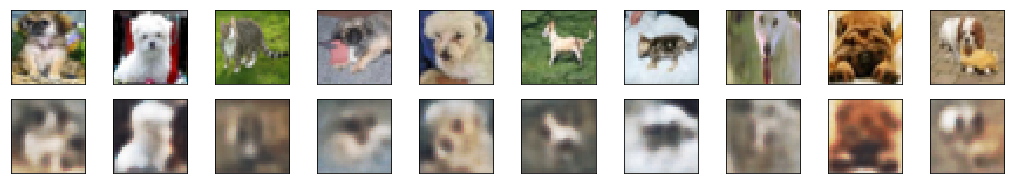

In [23]:
fig, ax = plt.subplots( 2, 10, figsize=(18, 3) )

for nn in range( 10 ):
    ax[0,nn].get_xaxis().set_visible( False )
    ax[0,nn].get_yaxis().set_visible( False )
    ax[1,nn].get_xaxis().set_visible( False )
    ax[1,nn].get_yaxis().set_visible( False )
    
    img = np.squeeze( train_im[nn,:,:,:] )
    rec = np.squeeze( train_re[nn,:,:,:] )
    
    ax[0,nn].imshow( img )
    ax[1,nn].imshow( rec )

# Visualize testing reconstruction
This always involves the full data set

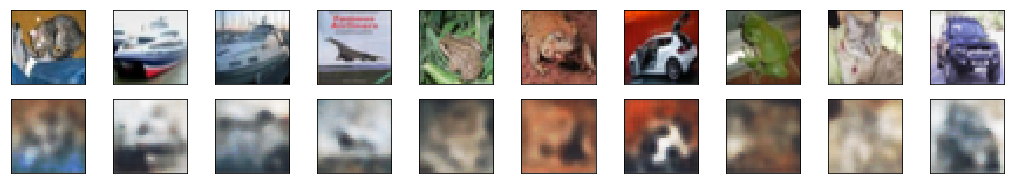

In [24]:
fig, ax = plt.subplots( 2, 10, figsize=(18, 3) )

for nn in range( 10 ):
    ax[0,nn].get_xaxis().set_visible( False )
    ax[0,nn].get_yaxis().set_visible( False )
    ax[1,nn].get_xaxis().set_visible( False )
    ax[1,nn].get_yaxis().set_visible( False )
    
    img = np.squeeze( test_im[nn,:,:,:] )
    rec = np.squeeze( test_re[nn,:,:,:] )
    
    ax[0,nn].imshow( img )
    ax[1,nn].imshow( rec )

In [25]:
with tf.Session() as sess:
    saver.restore( sess, ckpt_fname )
    
    sess.run( training_init_op, feed_dict={batch_size: train_batch_size, is_train: False} )
    images_, code_, recon_ = sess.run( [images, code, recon], feed_dict={is_train: False} )
    
# Now, we need to freeze the trained part of the network, attach a tan, and have it learn the likelihoods

INFO:tensorflow:Restoring parameters from ./ckpt/cifar-010-partial_30_Tensor("Placeholder:0", dtype=int64).ckpt


Let's take a look at the codes to try to get an idea of how separable they are

In [69]:
# restore_var = tf.contrib.slim.get_variables( scope='encoder' )

loader = tf.train.Saver() # restore_var )

train_codes = [[] for i in range(10)]
test_codes = [[] for i in range(10)]
with tf.Session() as sess:
    loader.restore( sess, ckpt_fname )
    
    cnt = 0
    sess.run( training_init_op, feed_dict={batch_size: 1} )
    while True:
        cnt += 1
        try:
            code_, label_ = sess.run( [code, labels], feed_dict={is_train: False} )
        except tf.errors.OutOfRangeError:
            break
        ind = np.argmax( label_ )
        # print( ind )
        train_codes[ind].append( code_ )
    
    cnt = 0
    sess.run( testing_init_op, feed_dict={batch_size: 1} )
    while True:
        cnt += 1
        try:
            code_, label_ = sess.run( [code, labels], feed_dict={is_train: False} )
        except tf.errors.OutOfRangeError:
            break
        ind = np.argmax( label_ )
        # print( ind )
        test_codes[ind].append( code_ )
            

INFO:tensorflow:Restoring parameters from ./ckpt/cifar-010-partial_30_Tensor("Placeholder:0", dtype=int64).ckpt


In [70]:
train_tmp = []
test_tmp  = []
for tt in range( 10 ):
    try:
        train_tmp.append( np.squeeze( np.asarray( train_codes[tt] ), 1 ).T )
    except:
        print( "Bad class {}".format( tt ) )
    test_tmp.append( np.squeeze( np.asarray(  test_codes[tt] ), 1 ).T )

train_codes = np.asarray( train_tmp )
test_codes  = np.asarray(  test_tmp )

train_W, train_U = np.linalg.eig( np.matmul( train_codes, train_codes.transpose( [0,2,1] ) ) )
test_W,   test_U = np.linalg.eig( np.matmul(  test_codes,  test_codes.transpose( [0,2,1] ) ) )

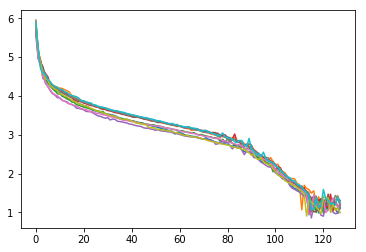

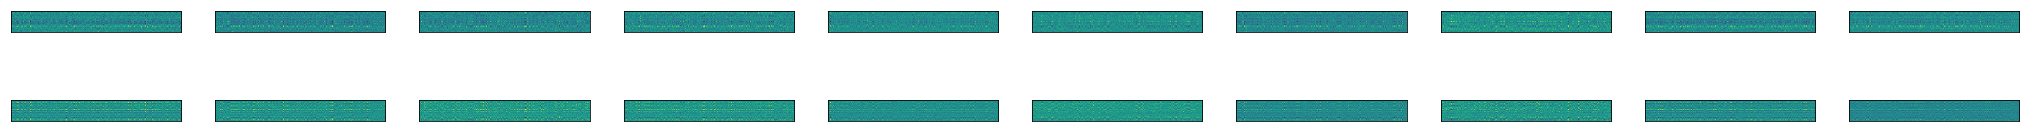

In [86]:
plt.plot( np.log10( test_W.T ) )

# Project the test data into the training data eigenspace
test_in_train = np.matmul( np.expand_dims( train_U, axis=0 ), np.expand_dims( test_codes, axis=1 ) )

fig, ax = plt.subplots( 2, 10, figsize=(36, 3) )

for nn in range( 10 ):
    ax[0,nn].get_xaxis().set_visible( False )
    ax[0,nn].get_yaxis().set_visible( False )
    ax[1,nn].get_xaxis().set_visible( False )
    ax[1,nn].get_yaxis().set_visible( False )
    
    cat = np.squeeze( test_in_train[nn,0,:,:] )
    dog = np.squeeze( test_in_train[nn,1,:,:] )
    
    ax[0,nn].imshow( cat )
    ax[1,nn].imshow( dog )

In [27]:
def loglikely( code ):
    with tf.variable_scope( 'loglikely' ):
        stop_layer = tf.stop_gradient( code )
        
        nll, samp = tan_nll( stop_layer )
        
        return nll, samp

In [28]:
nll, _ = loglikely( code )

global_step = tf.Variable(0, trainable=False)
learning_rate = tf.train.exponential_decay( 
    learning_rate=0.001, 
    global_step=global_step,
    decay_steps=int( ( 50000 / ( 2 * train_batch_size ) ) ), 
    decay_rate=0.99, 
    staircase=True
)

Building tan Graph,
	conditioning None
[<function log_rescale.<locals>.invmap at 0x7efe581d1268>, <function log_rescale.<locals>.invmap at 0x7efe581d11e0>, <function log_rescale.<locals>.invmap at 0x7efe581d1048>, <function log_rescale.<locals>.invmap at 0x7efe0f2efd90>, <function log_rescale.<locals>.invmap at 0x7efe0f2eff28>, <function log_rescale.<locals>.invmap at 0x7efe0f2efea0>, <function log_rescale.<locals>.invmap at 0x7efe70b47e18>, <function log_rescale.<locals>.invmap at 0x7efe70b47c80>, <function get_LU_map.<locals>.invmap at 0x7efe70ade620>]


In [29]:
# train_op = tf.train.MomentumOptimizer( learning_rate=learning_rate, momentum=0.9 ).minimize( nll )
# train_op = tf.train.AdamOptimizer( learning_rate=learning_rate ).minimize( nll )
nll_op = tf.train.RMSPropOptimizer( learning_rate ).minimize( nll )

It would be preferable if we could batch the nll and get the result per sample (instead of averaged over sample).
Obviously, for training, we don't care. But for testing per class, it would be much faster than running the tests with a batch size of 1.

In [30]:
NLL_EPOCHS = 25
nll_saver = tf.train.Saver()

# We need to be able to track the result per class
# The nll function is currently compressing over batch before we can get to it
nll_test_batch_size = 1
nll_train_batch_size = 64

if ( train_on_full ):
    nll_ckpt_fname = "./ckpt/cifar-010-nll-full_{}_{}.ckpt".format( NLL_EPOCHS, batch_size )
else:
    nll_ckpt_fname = "./ckpt/cifar-010-nll-partial_{}_{}.ckpt".format( NLL_EPOCHS, batch_size )

with tf.Session() as sess:
    # Initialize the session
    sess.run( tf.global_variables_initializer() )
    
    # Overload the encoder parameters with those already learned
    loader.restore( sess, ckpt_fname )
    
    all_train_nll = np.zeros( (NLL_EPOCHS) )
    all_test_nll = np.zeros( (10,NLL_EPOCHS) )
    all_test_loss = np.zeros( (10,NLL_EPOCHS) )
    for ee in range( NLL_EPOCHS ):
        
        cnt = 0
        train_nll = 0.0
        
        # Set up the training data
        sess.run( training_init_op, feed_dict={batch_size: nll_train_batch_size} )
        while True:
            try:
                # Test the nll
                _, nll_ = sess.run( [nll_op, nll], feed_dict={is_train: False} )
                cnt += 1
            except tf.errors.OutOfRangeError:
                break
            train_nll += nll_
        
        train_nll = train_nll / cnt
        print( "The average training nll at epoch {} was {} with {} steps.".format( ee, train_nll, cnt ) )
        all_train_nll[ee] = train_nll
        
        # if ee % 25 is not 0:
        #     continue
        
        cnt = 0
        # We can only track these stats at present if we use a batch size of 1
        test_nll = np.zeros( (10) )
        test_loss = np.zeros( (10) )
        # Run some number of testing batches in this epoch
        sess.run( testing_init_op, feed_dict={batch_size: nll_test_batch_size} )
        while True:
            try:
                # TODO: I need the nll and label per test example
                nll_, loss_, label_ = sess.run( [nll,loss,labels], feed_dict={is_train: False} )
                cnt += 1
            except tf.errors.OutOfRangeError:
                break
            ind = np.argmax( label_ )
            test_nll[ind] += nll_
            test_loss[ind] += loss_
        
        # x10 since the cnt is spread across all examples but we can only average per class
        test_nll = 10 * test_nll / cnt
        test_loss = 10 * test_loss / cnt
        print( "The average testing nll/loss at epoch {} was {}/{} with {} steps".format( 
            ee, np.mean( test_nll ), np.mean( test_loss ), cnt ) )
        all_test_nll[:,ee] = test_nll
        all_test_loss[:,ee] = test_loss
    
    nll_save_path = nll_saver.save( sess, nll_ckpt_fname )

INFO:tensorflow:Restoring parameters from ./ckpt/cifar-010-partial_30_Tensor("Placeholder:0", dtype=int64).ckpt
The average training nll at epoch 0 was 269.14693920428937 with 156 steps.
The average testing nll/loss at epoch 0 was 203.98336128540038/19.339613155467063 with 10000 steps
The average training nll at epoch 1 was 194.58300556280673 with 156 steps.
The average testing nll/loss at epoch 1 was 189.11402716674803/19.339613155467063 with 10000 steps
The average training nll at epoch 2 was 185.85241219936273 with 156 steps.
The average testing nll/loss at epoch 2 was 185.45418841857912/19.339613155467063 with 10000 steps
The average training nll at epoch 3 was 180.96828333536783 with 156 steps.
The average testing nll/loss at epoch 3 was 186.086475189209/19.339613155467063 with 10000 steps
The average training nll at epoch 4 was 176.74742948091946 with 156 steps.
The average testing nll/loss at epoch 4 was 186.27390887374878/19.339613155467063 with 10000 steps
The average training

In [31]:
test_loss = np.zeros( (10) )
print( np.shape( test_loss ) )

(10,)


In [32]:
print( np.shape( all_test_nll ) )
print( label_ )

(10, 25)
[[ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]]


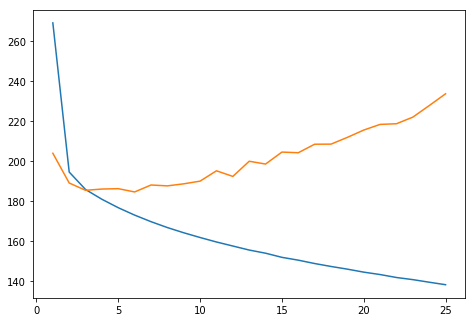

In [33]:
fig = plt.figure( )
ax = fig.add_axes( (0,0,1,1) )

x = np.arange( 1, NLL_EPOCHS+1 )
lin = ax.plot( x, np.array( all_train_nll ) )
lin = ax.plot( x, np.mean( np.array( all_test_nll ), axis=0 ) )

# Primary test
If this works as intended, we should see the nll go down for two of the lines and go up for the remaining lines.
If it goes up for all lines it means we're overfitting the training data.

In [34]:
print( np.argmax( label_ ) )

7


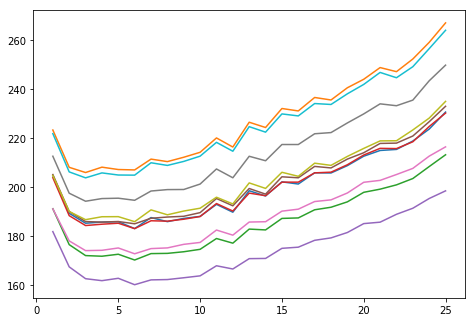

In [37]:
fig = plt.figure( )
ax = fig.add_axes( (0,0,1,1) )

lin = ax.plot( x, np.array( all_test_nll ).T )
ax.legend( ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], loc='upper left' )

The next cell illustrates the loss (not nll) of the test set.

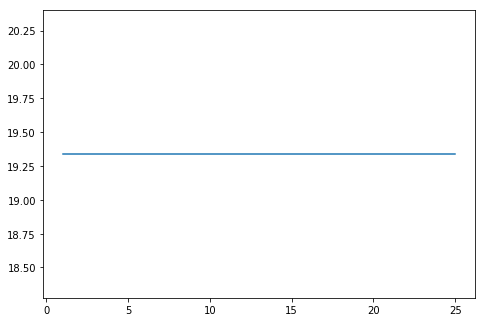

In [36]:
fig = plt.figure( )
ax = fig.add_axes( (0,0,1,1) )

lin = ax.plot( x, np.mean( np.array( all_test_loss ), axis=0 ) )